# Compare data with different calendars
**Claire Carouge, CLEX CMS**

Recently, someone contacted us for help to compute an ensemble mean over CMIP5 outputs from different models. He was looking at future projections which means the dates are outside the range covered by datetime64[ns] format. Additionally, neither model used the real calendar, one is using a 360 days calendar, the other is using a No Leap Year calendar. In that case, Xarray will default to using [cftime](https://unidata.github.io/cftime/) objects to represent the dates using the calendar provided in the file.  

Because of the way CMIP5 experiments are designed, in addition to using different calendars, both models also covered a slightly different time period. All this means, the data has to be manually aligned in time before we can average across the model dimension. This cannot be done automatically by Xarray.

When dealing with different calendars, the way to align the dates depends on what you are interested in. In our case, we didn't care about the exact length of the month in days, the value for February 2100 represents the same month whether this month is 28 days in the No Leap calendar or 30 days in the 360 days calendar. This means we have a relatively simple problem. We don't need to worry about weighting of the data when changing calendar, or masking data out. Masking data or weighting data would be necessary for changing daily data from a No Leap calendar (365 values per year) to a 360 day calendar (only 360 values per year). Deciding which technique to use would be for the researcher to decide depending on what would make sense scientifically.

For our simpler problem, we decided we could "cut" the precision of the date to the month and move all the dates to the same calendar. We are going to describe in this blog how this was done on a very simple example.

In [1]:
import xarray as xr
import cftime
%matplotlib inline

# Inputs

In [2]:
#HADGEM and BCC
filename=[ \
          '/g/data1b/al33/replicas/CMIP5/combined/MOHC/HadGEM2-ES/rcp85/mon/atmos/Amon/r1i1p1/v20130430/pr/'+'pr_Amon_HadGEM2-ES_rcp85_r1i1p1_227412-229911.nc', \
          '/g/data1b/al33/replicas/CMIP5/combined/BCC/bcc-csm1-1/rcp85/mon/atmos/Amon/r1i1p1/v20120705/pr/'+'pr_Amon_bcc-csm1-1_rcp85_r1i1p1_210001-230012.nc'   \
         ]

We'll read the files and keep all the data in a list called `var_list`. We don't need anything fancier than a list because we are keeping all the metadata we need to identify our data with the DataArray itself. You could choose to keep the data in a dictionary instead and use the `model_id` as your dictionary keys. This would allow you to select your data using the model name. If you do so, I would still advise to add the `model_id` (or any other identifying data) with the array itself using coordinates, as it is done below. This keeps the data self-describing which is the point of the Xarray and netCDF philosophies.

In [3]:
var_list = []
for ffile in filename:
    ds = xr.open_dataset(ffile)
    # Let's grab the model name from the attributes and add as a coordinate. 
    # That will help with doing averages across the mode dimension. 
    # Additionally, the model_id information is kept when looking at the variable itself 
    # when using a coordinate while the global attribute is lost.
    ds = ds.assign_coords({'model_id':ds.model_id})
    var_list.append(ds['pr'])
print(var_list[0],'\n',var_list[1])

<xarray.DataArray 'pr' (time: 300, lat: 145, lon: 192)>
[8352000 values with dtype=float32]
Coordinates:
  * time      (time) object 2274-12-16 00:00:00 ... 2299-11-16 00:00:00
  * lat       (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    model_id  <U10 'HadGEM2-ES'
Attributes:
    standard_name:     precipitation_flux
    long_name:         Precipitation
    comment:           at surface; includes both liquid and solid phases from...
    units:             kg m-2 s-1
    original_name:     mo: m01s05i216
    history:           2011-11-24T09:57:29 out-of-bounds adjustments: (-1e-07...
    cell_methods:      time: mean
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation... 
 <xarray.DataArray 'pr' (time: 2412, lat: 64, lon: 128)>
[19759104 values with dtype=float32]
Coordinates:
  * time      (time) object 2100-01-16 12:0

## Time coordinates
We can see those models are quite different. Different grids, different time periods. But there is an additional difference which isn't obvious with this printing and it is the calendars. Let's have a closer look at the time coordinates:

In [4]:
var_list[0].time

<xarray.DataArray 'time' (time: 300)>
array([cftime.Datetime360Day(2274, 12, 16, 0, 0, 0, 0, 6, 346),
       cftime.Datetime360Day(2275, 1, 16, 0, 0, 0, 0, 1, 16),
       cftime.Datetime360Day(2275, 2, 16, 0, 0, 0, 0, 3, 46), ...,
       cftime.Datetime360Day(2299, 9, 16, 0, 0, 0, 0, 5, 256),
       cftime.Datetime360Day(2299, 10, 16, 0, 0, 0, 0, 0, 286),
       cftime.Datetime360Day(2299, 11, 16, 0, 0, 0, 0, 2, 316)], dtype=object)
Coordinates:
  * time      (time) object 2274-12-16 00:00:00 ... 2299-11-16 00:00:00
    model_id  <U10 'HadGEM2-ES'
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [5]:
var_list[1].time

<xarray.DataArray 'time' (time: 2412)>
array([cftime.DatetimeNoLeap(2100, 1, 16, 12, 0, 0, 0, 1, 16),
       cftime.DatetimeNoLeap(2100, 2, 15, 0, 0, 0, 0, 3, 46),
       cftime.DatetimeNoLeap(2100, 3, 16, 12, 0, 0, 0, 4, 75), ...,
       cftime.DatetimeNoLeap(2300, 10, 16, 12, 0, 0, 0, 5, 289),
       cftime.DatetimeNoLeap(2300, 11, 16, 0, 0, 0, 0, 1, 320),
       cftime.DatetimeNoLeap(2300, 12, 16, 12, 0, 0, 0, 3, 350)], dtype=object)
Coordinates:
  * time      (time) object 2100-01-16 12:00:00 ... 2300-12-16 12:00:00
    model_id  <U10 'bcc-csm1-1'
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

We can see the time coordinates aren't datetime64[ns] objects as is usually the case for DataArray objects. This is because the models don't use the Gregorian calendar. In that case, Xarray defaults to cftime objects. But then, the objects are different depending on the calendar used in the file. As you can see HadGEM2-ES is using a 360_day calendar while BCC_CSM1.1 is using a NoLeap calendar. 

Having 2 calendars means months don't have the same length in both models. In our case, it doesn't matter as we don't care for data at a finer scale than the month. We also don't want to weight the data in any way by the length of the month. This also means we do not care about the day, hour etc. of the date. Whether the date is 2100/02/15 12:00:00 or 2100/02/27 00:00:00, both dates would represent the same data.

## Spatial grid mismatch
These 2 models use different spatial grids. You cannot compare them at the grid cell level while on different grids. One would have to interpolate the data to a common grid before doing that. Xarray provides the `interp()` method to deal with that for example.

Here we are going to keep things simple and simply look at a Northern Hemisphere average so that we remove the spatial dimension altogether.

In [6]:
for ii in range(len(var_list)):
    var_list[ii] = var_list[ii].sel(lat=[0., 90.],method='nearest').mean(dim=['lon','lat'])
print(var_list[0],'\n',var_list[1])

<xarray.DataArray 'pr' (time: 300)>
array([3.64325097e-05, 4.27831728e-05, 3.92413967e-05, 4.56348062e-05,
       6.77763601e-05, 7.60465846e-05, 5.75202830e-05, 3.32962081e-05,
       3.24944958e-05, 2.62415069e-05, 3.26726295e-05, 3.26325171e-05,
       3.14639801e-05, 3.01010750e-05, 1.83014763e-05, 2.17203506e-05,
       4.41498742e-05, 6.74383700e-05, 5.94772682e-05, 4.54635920e-05,
       4.01743928e-05, 2.49527602e-05, 1.79039071e-05, 3.73657967e-05,
       4.09420027e-05, 3.00161100e-05, 2.47476764e-05, 2.80293734e-05,
       5.12982551e-05, 6.39619902e-05, 7.37399969e-05, 5.08287230e-05,
       3.63605941e-05, 1.45873200e-05, 2.69833417e-05, 2.63794154e-05,
       3.28406932e-05, 5.15875618e-05, 4.20846372e-05, 4.35442489e-05,
       4.25339240e-05, 5.28369601e-05, 6.19484199e-05, 3.61547754e-05,
       2.46096697e-05, 2.87036473e-05, 3.83880979e-05, 2.82257261e-05,
       3.83581246e-05, 3.57428253e-05, 2.66543047e-05, 3.79485609e-05,
       4.66462188e-05, 4.64161421e-05, 6.

## Align the times
Finally, we can deal with the time coordinates. What we'll do is put all the dates on a 360 day calendar for the middle of the month. Since all months have 30 days in a 360 day calendar, the mid-month mark is on 16th 00:00:00. There is no automatic way to change from one calendar to another because the way you want to do it depends on why you are doing it. Here we are going to get the year and month for each date and put them as arguments of the `cftime.Datetime360Day()` function which sets the date for the 360 day calendar.

In [11]:
def to_360day_monthly(da):
    '''Takes a DataArray. Change the 
    calendar to 360_day and precision to monthly.'''
    val = da.copy()
    time1 = da.time.copy()
    for itime in range(val.sizes['time']):
        bb = val.time.values[itime].timetuple()
        time1.values[itime] = cftime.Datetime360Day(bb[0],bb[1],16)

    # We rename the time dimension and coordinate to time360 to make it clear it isn't 
    # the original time coordinate.
    val = val.rename({'time':'time360'})
    time1 = time1.rename({'time':'time360'})
    val = val.assign_coords({'time360':time1})
    return val

In [12]:
ll = [to_360day_monthly(da) for da in var_list]
print(ll[0].time360)
print(ll[1].time360)

<xarray.DataArray 'time360' (time360: 300)>
array([cftime.Datetime360Day(2274, 12, 16, 0, 0, 0, 0, 6, 346),
       cftime.Datetime360Day(2275, 1, 16, 0, 0, 0, 0, 1, 16),
       cftime.Datetime360Day(2275, 2, 16, 0, 0, 0, 0, 3, 46), ...,
       cftime.Datetime360Day(2299, 9, 16, 0, 0, 0, 0, 5, 256),
       cftime.Datetime360Day(2299, 10, 16, 0, 0, 0, 0, 0, 286),
       cftime.Datetime360Day(2299, 11, 16, 0, 0, 0, 0, 2, 316)], dtype=object)
Coordinates:
  * time360   (time360) object 2274-12-16 00:00:00 ... 2299-11-16 00:00:00
    model_id  <U10 'HadGEM2-ES'
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
<xarray.DataArray 'time360' (time360: 2412)>
array([cftime.Datetime360Day(2100, 1, 16, 0, 0, 0, 0, 1, 16),
       cftime.Datetime360Day(2100, 2, 16, 0, 0, 0, 0, 3, 46),
       cftime.Datetime360Day(2100, 3, 16, 0, 0, 0, 0, 5, 76), ...,
       cftime.Datetime360Day(2300, 10, 16, 0, 0, 0, 0, 3, 286),
       cftime.Datetime3

We now have the same calendar and all dates refer to the middle of the month. We can concatenate the arrays together with `xarray.concat()` and xarray will align the arrays correctly. Make sure the dates that are common to both models are the same, otherwise Xarray might keep both sets. This would result in additional times in both models filled with NaN. Additionally, the data from both models would never be considered as having the same time and as such you wouldn't be able to do a mean.

First, we are going to concatenate the data using the union of the time periods covered by both models

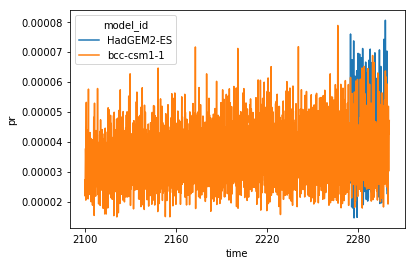

In [13]:
full_da = xr.concat(ll, 'model_id', join='outer')
# When plotting the data, you can see the HadGEM2-ES data is 
# correctly placed at the end of the timeseries.
full_da.plot(hue='model_id')

In [14]:
full_da

<xarray.DataArray 'pr' (model_id: 2, time360: 2412)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [2.7216340e-05, 2.1928223e-05, 2.5535373e-05, ..., 4.2512460e-05,
        4.3559990e-05, 4.7103615e-05]], dtype=float32)
Coordinates:
  * time360   (time360) object 2100-01-16 00:00:00 ... 2300-12-16 00:00:00
  * model_id  (model_id) object 'HadGEM2-ES' 'bcc-csm1-1'

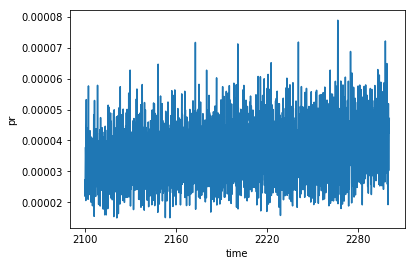

In [15]:
# Calculating the model mean is then trivial
full_da.mean(dim='model_id').plot()

Obviously, you may want to keep only the dates when you have data from all models. For this you simply change the `join` argument of concat:

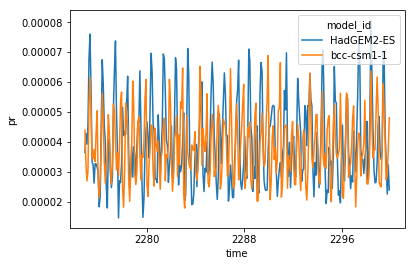

In [16]:
inter_da = xr.concat(ll,'model_id',join='inner')
inter_da.plot(hue='model_id')

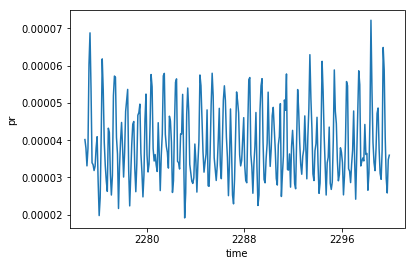

In [17]:
inter_da.mean(dim='model_id').plot()

## Keep the original dates
A potential issue with the above method is we loose the original dates associated with the data. Here is a solution to keep both time coordinates.

In [18]:
def to_360day_monthly_both(da):
    '''Takes a DataArray. Change the 
    calendar to 360_day and precision to monthly.'''
    val = da.copy()
    time1 = da.time.copy()
    for itime in range(val.sizes['time']):
        bb = val.time.values[itime].timetuple()
        time1.values[itime] = cftime.Datetime360Day(bb[0],bb[1],16)

    # Instead of renaming the time dimension and coordinate. We first add the
    # new coordinate with the time360 name, then we swap the dimension. 
    # This tells Xarray to now use time360 as a dimension and coordinate for this
    # array.
    val = val.assign_coords({'time360':time1})
    val = val.swap_dims({'time':'time360'})
    return val

In [19]:
ll = [to_360day_monthly_both(da) for da in var_list]
print(ll[0].time360)
print(ll[1].time360)

<xarray.DataArray 'time360' (time360: 300)>
array([cftime.Datetime360Day(2274, 12, 16, 0, 0, 0, 0, 6, 346),
       cftime.Datetime360Day(2275, 1, 16, 0, 0, 0, 0, 1, 16),
       cftime.Datetime360Day(2275, 2, 16, 0, 0, 0, 0, 3, 46), ...,
       cftime.Datetime360Day(2299, 9, 16, 0, 0, 0, 0, 5, 256),
       cftime.Datetime360Day(2299, 10, 16, 0, 0, 0, 0, 0, 286),
       cftime.Datetime360Day(2299, 11, 16, 0, 0, 0, 0, 2, 316)], dtype=object)
Coordinates:
    time      (time360) object 2274-12-16 00:00:00 ... 2299-11-16 00:00:00
    model_id  <U10 'HadGEM2-ES'
  * time360   (time360) object 2274-12-16 00:00:00 ... 2299-11-16 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
<xarray.DataArray 'time360' (time360: 2412)>
array([cftime.Datetime360Day(2100, 1, 16, 0, 0, 0, 0, 1, 16),
       cftime.Datetime360Day(2100, 2, 16, 0, 0, 0, 0, 3, 46),
       cftime.Datetime360Day(2100, 3, 16, 0, 0, 0, 0, 5, 76), ...,
       cftim

In [20]:
# Look at what happens to the time coordinate after the concatenation:
full_da = xr.concat(ll, 'model_id', join='outer')
full_da

<xarray.DataArray 'pr' (model_id: 2, time360: 2412)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [2.7216340e-05, 2.1928223e-05, 2.5535373e-05, ..., 4.2512460e-05,
        4.3559990e-05, 4.7103615e-05]], dtype=float32)
Coordinates:
  * time360   (time360) object 2100-01-16 00:00:00 ... 2300-12-16 00:00:00
    time      (model_id, time360) object nan nan ... 2300-12-16 12:00:00
  * model_id  (model_id) object 'HadGEM2-ES' 'bcc-csm1-1'

The `time` coordinate only has values where the original data had a date.

In [21]:
full_da.time.sel(model_id='HadGEM2-ES',time360=slice('2273-01','2275-01'))

<xarray.DataArray 'time' (time360: 25)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       cftime.Datetime360Day(2274, 12, 16, 0, 0, 0, 0, 6, 346),
       cftime.Datetime360Day(2275, 1, 16, 0, 0, 0, 0, 1, 16)],
      dtype=object)
Coordinates:
  * time360   (time360) object 2273-01-16 00:00:00 ... 2275-01-16 00:00:00
    time      (time360) object nan nan ... 2275-01-16 00:00:00
    model_id  <U10 'HadGEM2-ES'
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/plot/plot.py:86: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  yplt = darray.transpose(xname, huename)


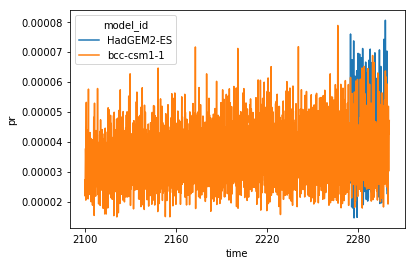

In [22]:
full_da.plot(hue='model_id')

In [23]:
full_da.mean(dim='model_id')

<xarray.DataArray 'pr' (time360: 2412)>
array([2.7216340e-05, 2.1928223e-05, 2.5535373e-05, ..., 4.2512460e-05,
       4.3559990e-05, 4.7103615e-05], dtype=float32)
Coordinates:
  * time360  (time360) object 2100-01-16 00:00:00 ... 2300-12-16 00:00:00

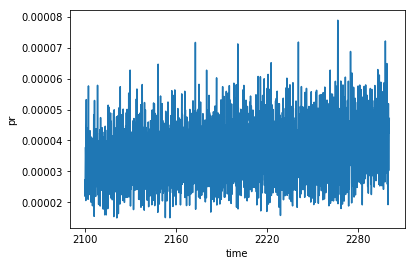

In [24]:
full_da.mean(dim='model_id').plot()

# Conclusion
We presented here two simple ways to change calendar for monthly data. Feel free to use either of the functions presented here. Please, remember this solution works well for the problem presented here. Other problems may require different approaches.